In [1]:
import torch

from customize_minigrid.custom_env import CustomEnv
import matplotlib.pyplot as plt
import numpy as np
from mdp_learner import OneHotEncodingMDPLearner
from customize_minigrid.wrappers import FullyObsSB3MLPWrapper
from mdp_graph.mdp_graph import MDPGraph, PolicyGraph, OptimalPolicyGraph

pygame 2.6.0 (SDL 2.28.4, Python 3.8.20)
Hello from the pygame community. https://www.pygame.org/contribute.html


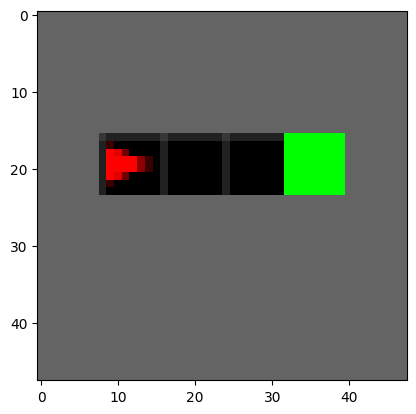

In [2]:
file_path = r"./maps/short_corridor.txt"
env = CustomEnv(
        txt_file_path=file_path,
        rand_gen_shape=None,
        display_size=None,
        display_mode="middle",
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        random_rotate=False,
        random_flip=False,
        custom_mission="Find the key and open the door.",
        render_mode=None,
    )
env.reset()
img = env.get_frame(False, env.tile_size, env.agent_pov)
plt.imshow(img)
plt.show()

In [3]:
from customize_minigrid.wrappers import FullyObsImageWrapper

env = FullyObsImageWrapper(env, to_print=False)
learner = OneHotEncodingMDPLearner(env)
learner.learn()

/home/bentengma/work_space/mini-grid-curriculum/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/bentengma/work_space/mini-grid-curriculum/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/bentengma/work_space/mini-grid-curriculum/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


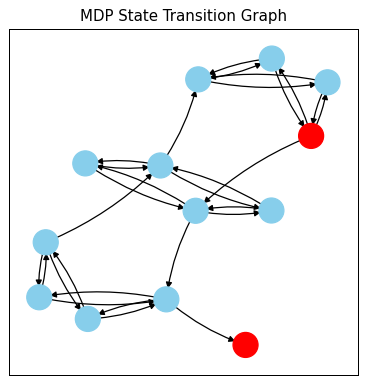

In [4]:
optimal_graph = OptimalPolicyGraph()
optimal_graph.load_graph(learner.mdp_graph)
optimal_graph.uniform_prior_policy()
optimal_graph.visualize(highlight_states=[learner.start_state, *learner.done_states], use_grid_layout=False, display_state_name=False)

In [5]:
optimal_graph.optimal_value_iteration(0.999, threshold=1e-5)
optimal_graph.compute_optimal_policy(0.999, threshold=1e-5)
optimal_graph.control_info_iteration(1.0, threshold=1e-5)
optimal_graph.value_iteration(1.0, threshold=1e-5)

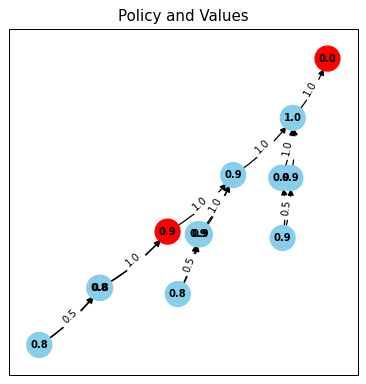

In [6]:
optimal_graph.visualize_policy_and_values(title="Policy and Values", value_type="value",
                                              highlight_states=[learner.start_state, *learner.done_states],
                                              use_grid_layout=False, display_state_name=False)

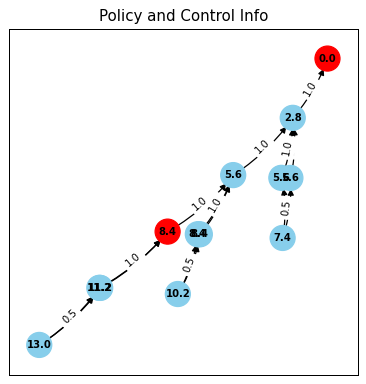

In [7]:
optimal_graph.visualize_policy_and_values(title="Policy and Control Info", 
                                          value_type="control_info",
                                          highlight_states=[learner.start_state, *learner.done_states],
                                          use_grid_layout=False, display_state_name=False)

In [8]:
# from stable_baselines3 import PPO
# 
# load_path = r'experiments/mazes-bin-16/run0/saved_models/saved_model_latest.zip'
# model = PPO.load(load_path, env=env)
# feature_model = model.policy.features_extractor
# feature_model.binary_output = True
# feature_model.to("cpu")

In [9]:
# import torch
# from binary_state_representation.binary2binaryautoencoder import Binary2BinaryFeatureNet
# from minigrid_abstract_encoding import EncodingMDPLearner
# 
# 
# device = "cuda" if torch.cuda.is_available() else "cpu"
# 
# NUM_ACTIONS = int(env.action_space.n)
# OBS_SPACE = int(env.total_features)
# LATENT_DIMS = 24
# print(NUM_ACTIONS, OBS_SPACE, LATENT_DIMS)
# 
# # train hyperparams
# WEIGHTS = {'inv': 1.0, 'dis': 1.0, 'neighbour': 0.0, 'dec': 0.0, 'rwd': 0.1, 'terminate': 1.0}
# BATCH_SIZE = 32
# LR = 1e-4
# 
# model = Binary2BinaryFeatureNet(NUM_ACTIONS, OBS_SPACE, n_latent_dims=LATENT_DIMS, lr=LR, weights=WEIGHTS, device=device, )
# 
# model.load(r'experiments/learn_feature_corridor_24/model_epoch_200.pth')
# model.use_bin = True
# 
# encoder = model.encoder.to(device)

In [10]:
# from minigrid_abstract_encoding import EncodingMDPLearner
# 
# learner = EncodingMDPLearner(env, feature_model, torch.device("cpu"), keep_dims=feature_model.features_dim)
# learner.learn()
# optimal_graph = OptimalPolicyGraph()
# optimal_graph.load_graph(learner.mdp_graph)
# optimal_graph.uniform_prior_policy()
# optimal_graph.visualize(highlight_states=[learner.encoded_start_state, *learner.encoded_done_states], use_grid_layout=False, display_state_name=True)
# 
# max_cols = 3
# for state in learner.encoded_state_set:
#     images = learner.encoded_state_to_unencoded_state_dict[state]
#     num_images = len(images)
#     num_rows = (num_images + max_cols - 1) // max_cols
#     num_cols = min(num_images, max_cols)
#     plt.figure(figsize=(num_cols * 5, num_rows * 5))
#     for i, unencoded in enumerate(images):
#         img = learner.unencoded_state_image_dict[unencoded]
#         plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(img)
#         plt.axis('off')
#     plt.suptitle(state)
#     plt.tight_layout()
#     plt.show()

/home/bentengma/work_space/mini-grid-curriculum/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/bentengma/work_space/mini-grid-curriculum/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/bentengma/work_space/mini-grid-curriculum/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
2 7
2 14
4 14
7 28
9 49
10 63
11 70
11 70
10 70
11 70
8 70
2 49
0 14
0 0


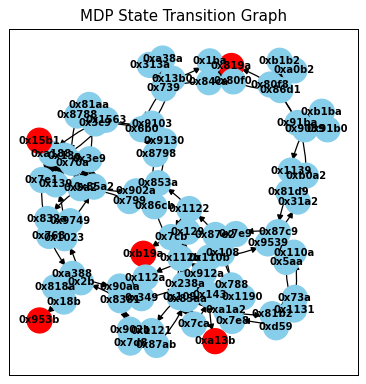

In [11]:
from minigrid_abstract_encoding import EncodingMDPLearner
from stable_baselines3 import PPO
env = CustomEnv(
        txt_file_path=f'./maps/7-1.txt',
        rand_gen_shape=None,
        display_size=7,
        display_mode="middle",
        agent_start_pos=(5, 5),
        agent_start_dir=0,
        random_rotate=False,
        random_flip=False,
        custom_mission="Find the key and open the door.",
        render_mode=None,
    )
env = FullyObsImageWrapper(env, to_print=False)
load_path = r'experiments/mazes-bin-16/run0/saved_models/saved_model_latest.zip'
model = PPO.load(load_path, env=env)
feature_model = model.policy.features_extractor
feature_model.binary_output = True
feature_model.to("cpu")
encoding_learner = EncodingMDPLearner(env, feature_model, torch.device("cpu"), keep_dims=feature_model.features_dim)
encoding_learner.learn()
optimal_graph = OptimalPolicyGraph()
optimal_graph.load_graph(encoding_learner.mdp_graph)
optimal_graph.uniform_prior_policy()
optimal_graph.visualize(highlight_states=[encoding_learner.encoded_start_state, *encoding_learner.encoded_done_states], use_grid_layout=False, display_state_name=True)

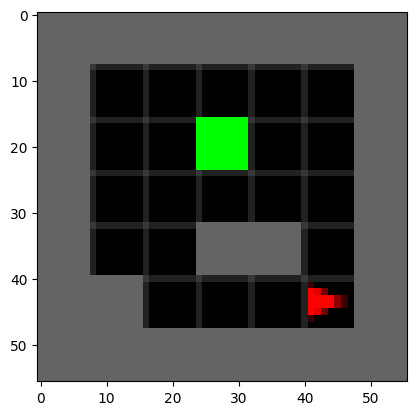

/home/bentengma/work_space/mini-grid-curriculum/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/bentengma/work_space/mini-grid-curriculum/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/bentengma/work_space/mini-grid-curriculum/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


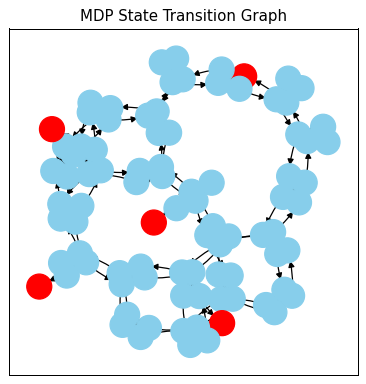

2 7
2 14
4 14
7 28
9 49
10 63
11 70
11 70
10 70
11 70
8 70
2 49
0 14
0 0


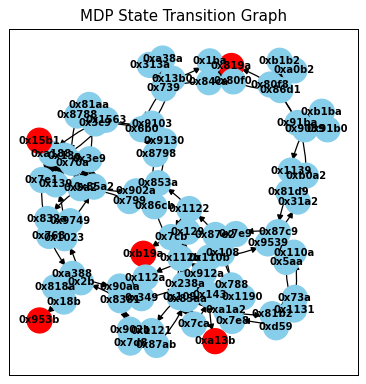

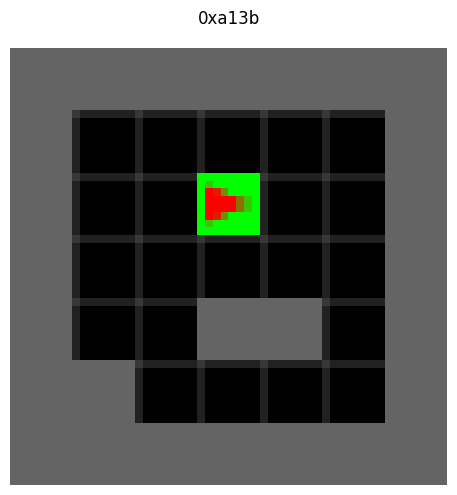

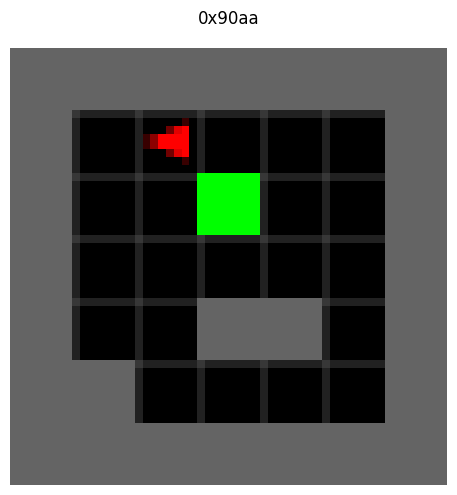

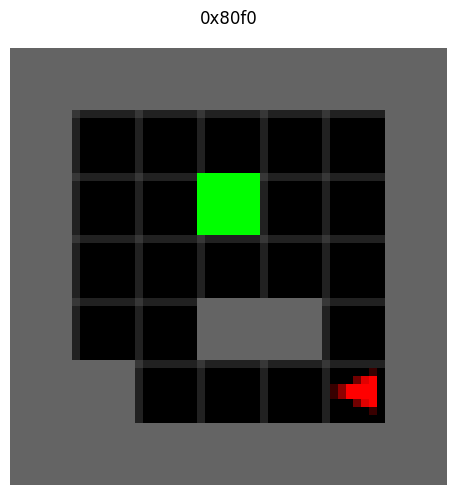

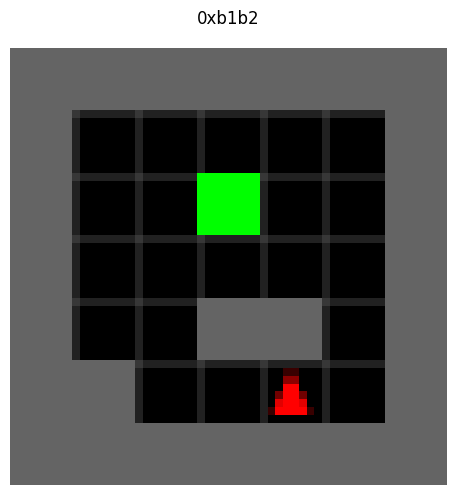

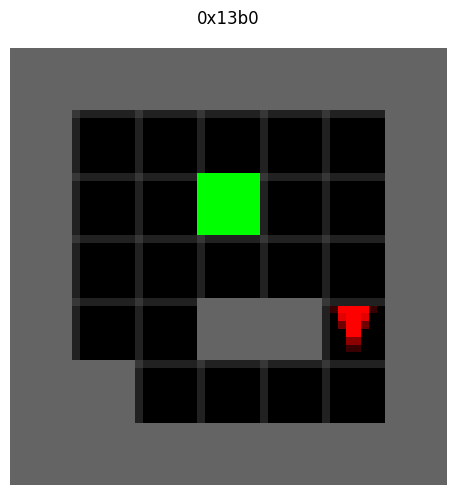

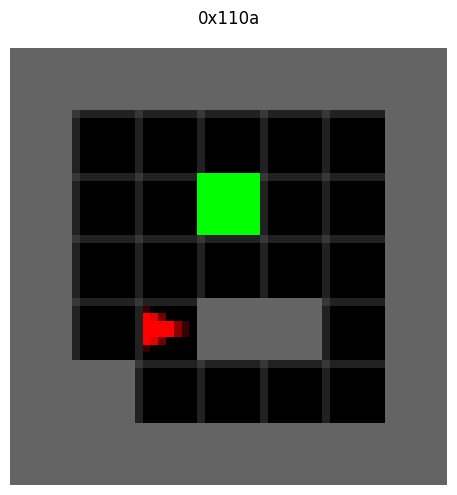

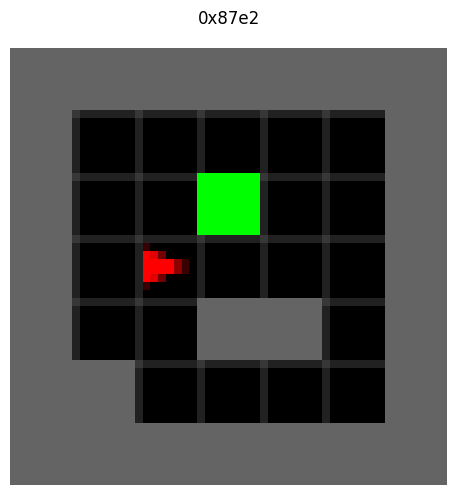

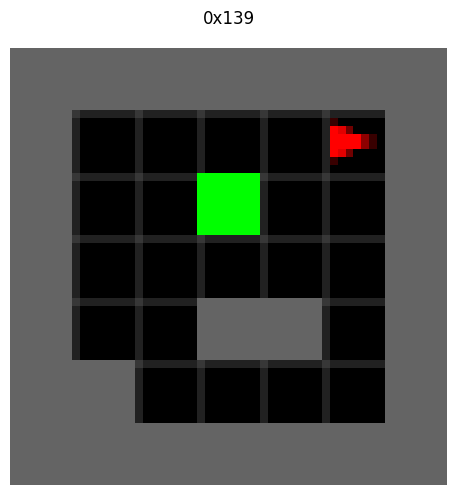

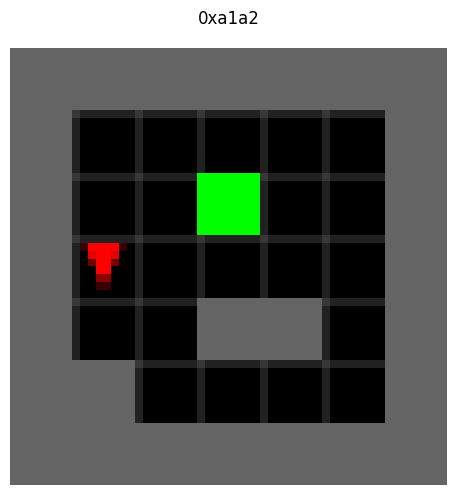

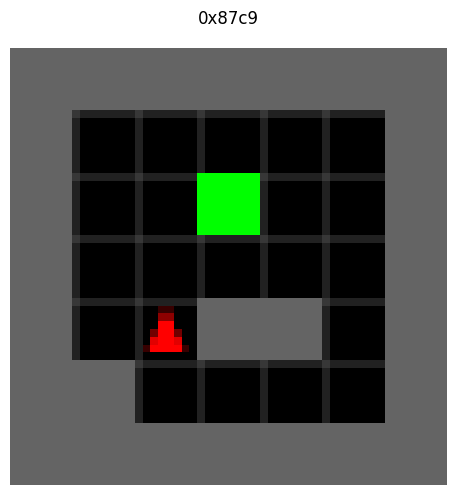

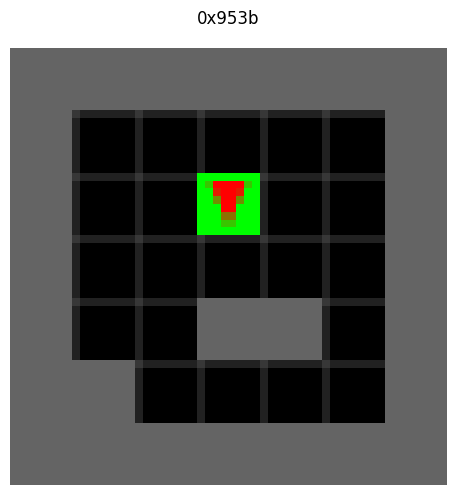

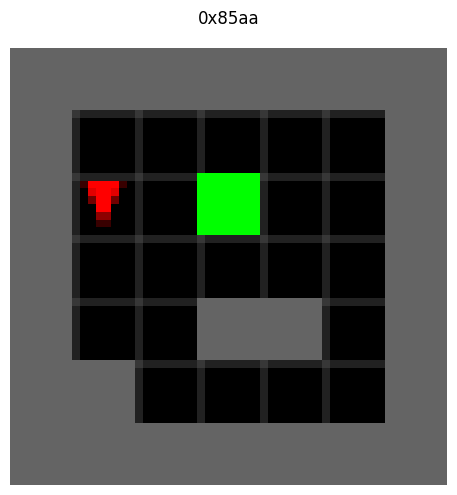

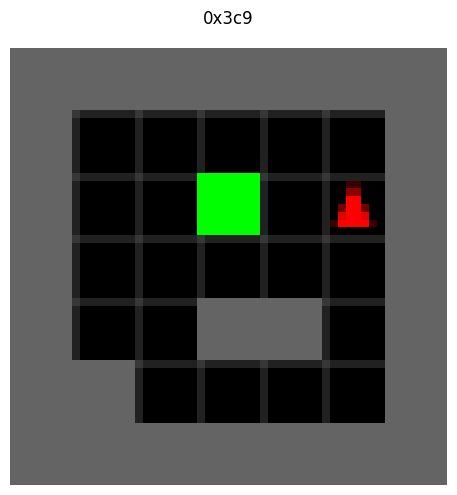

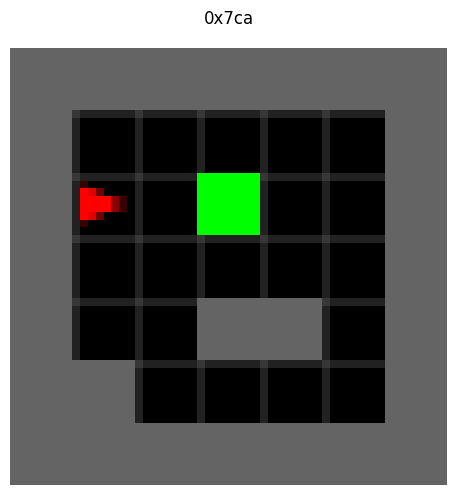

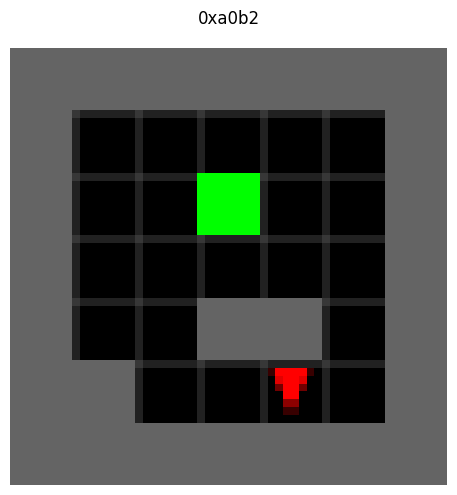

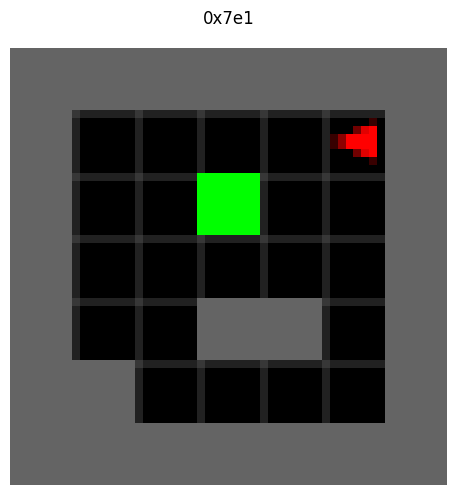

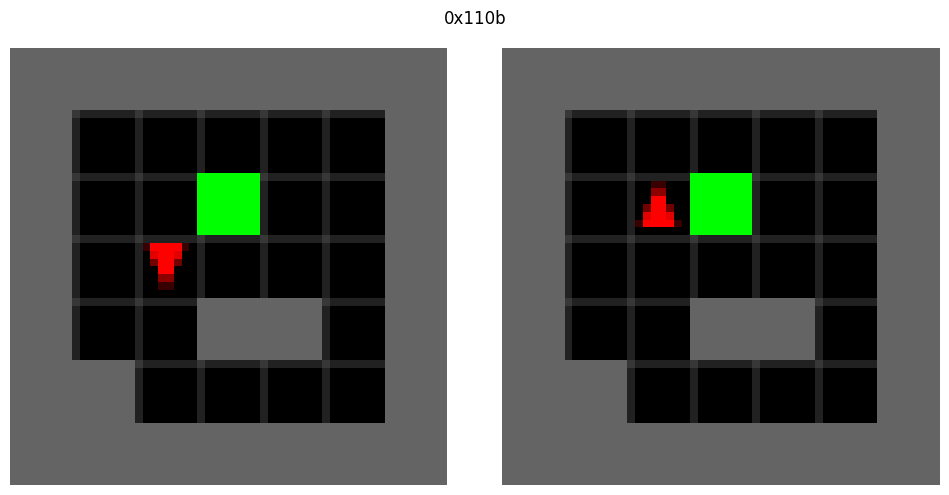

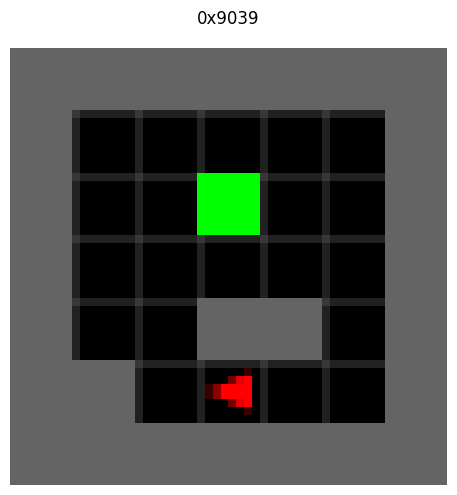

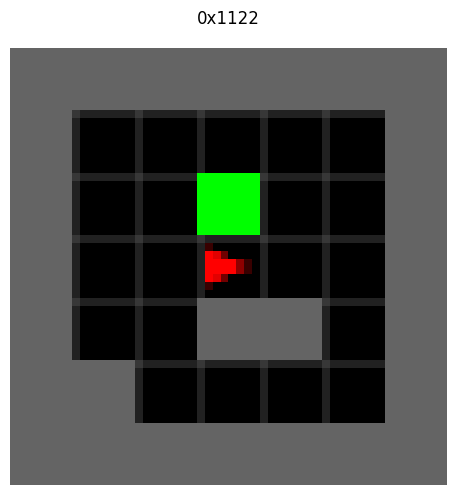

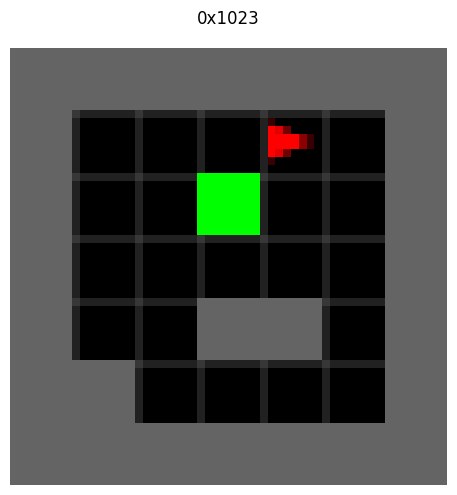

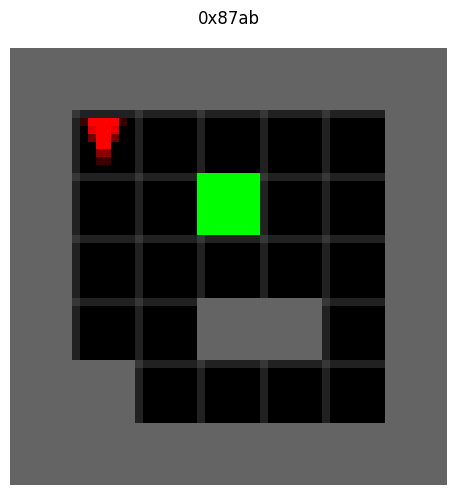

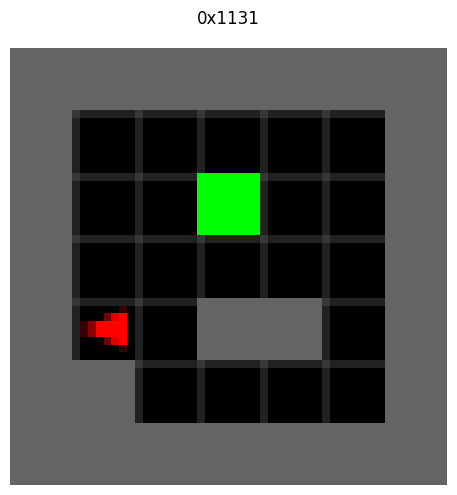

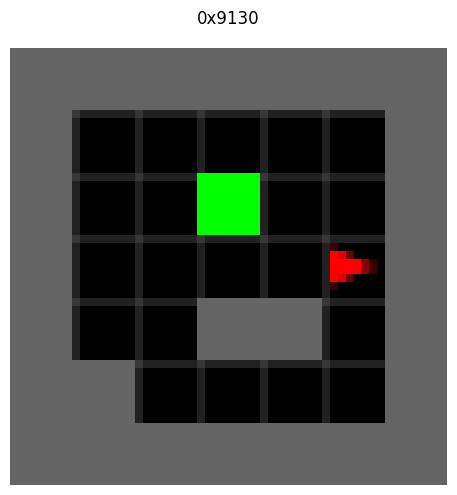

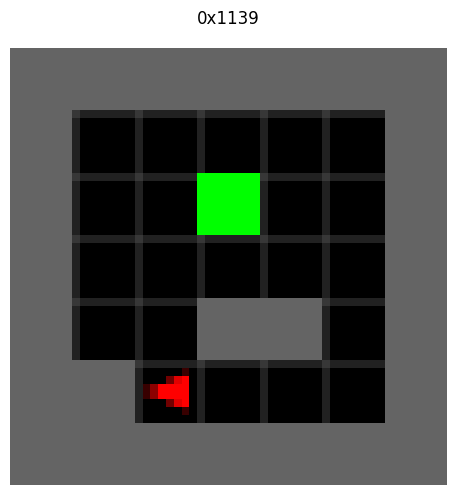

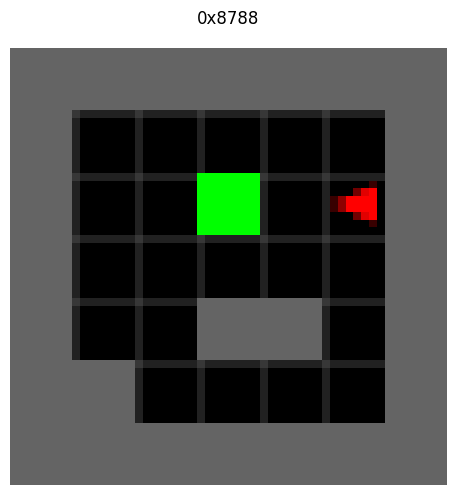

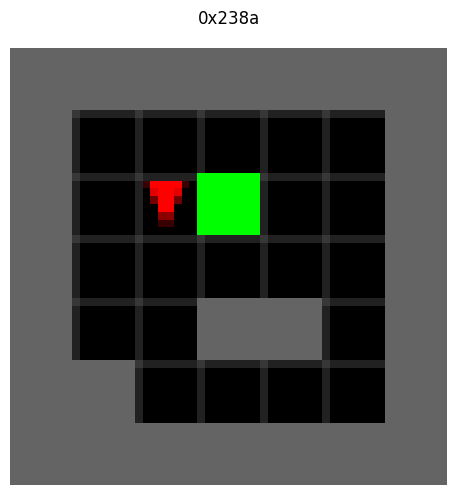

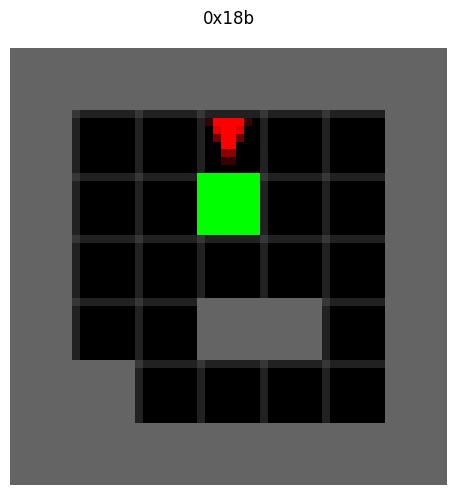

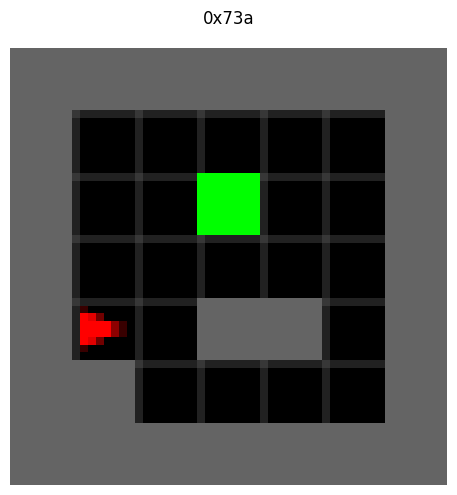

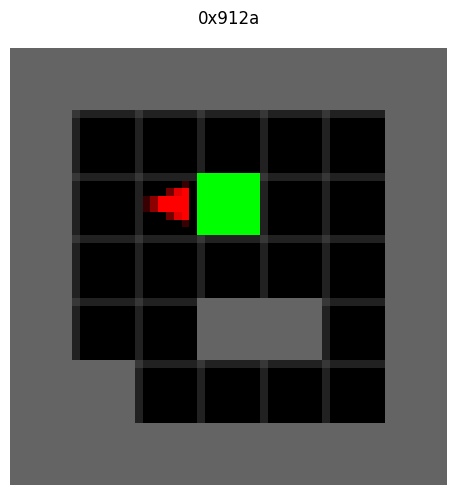

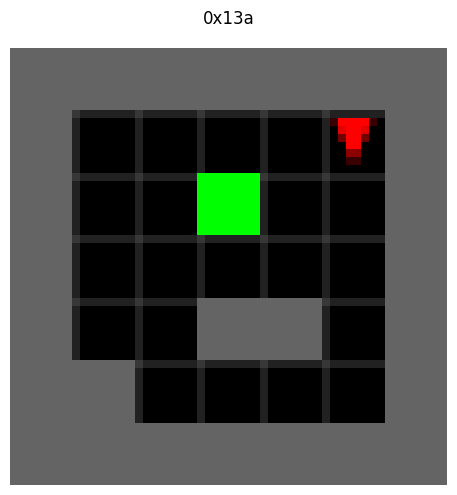

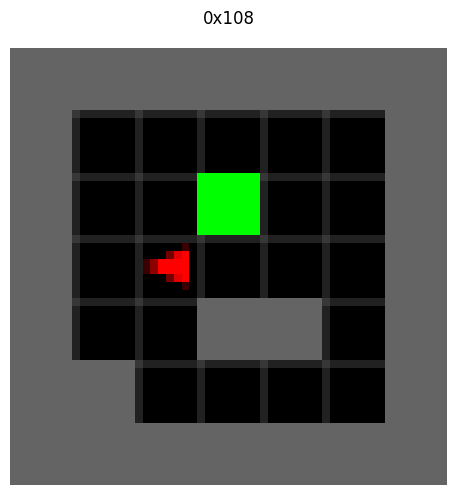

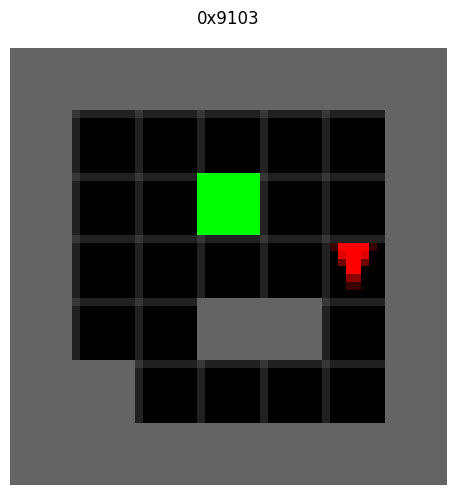

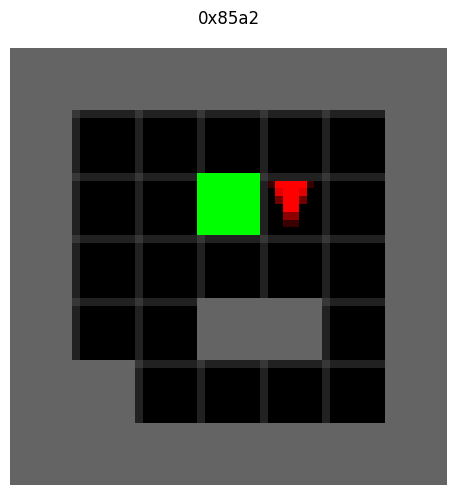

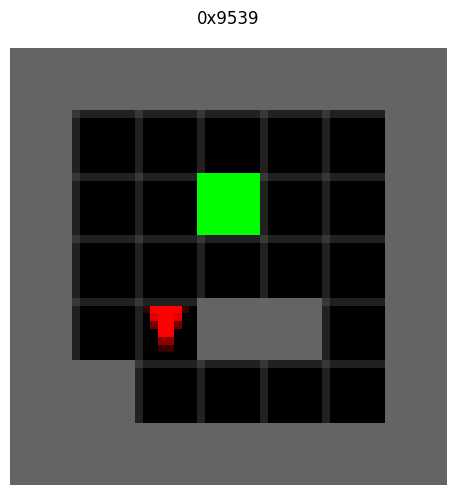

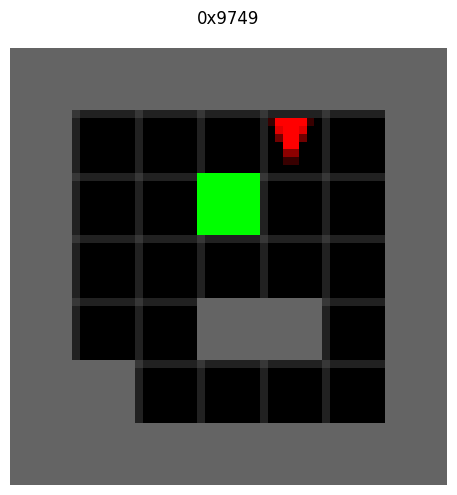

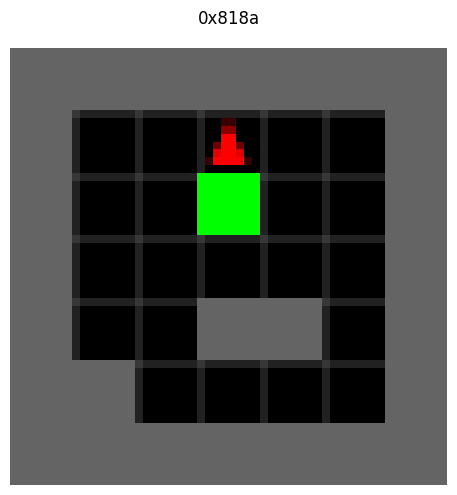

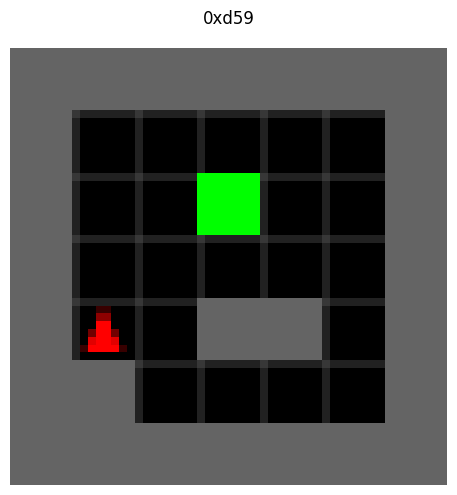

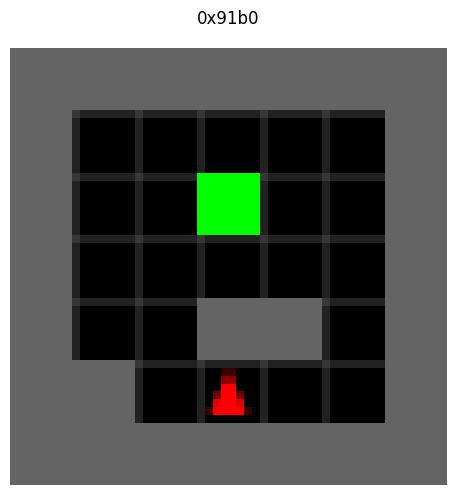

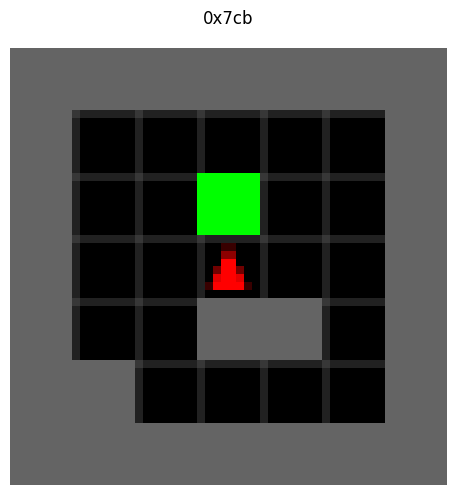

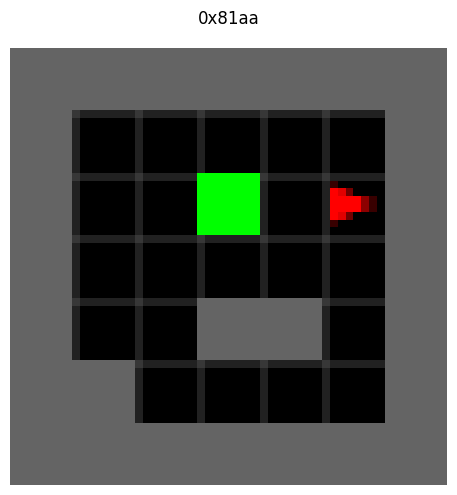

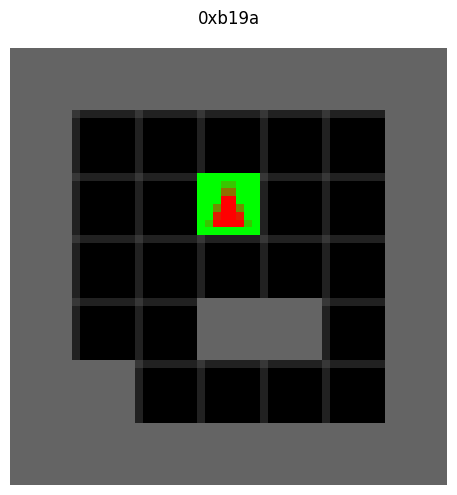

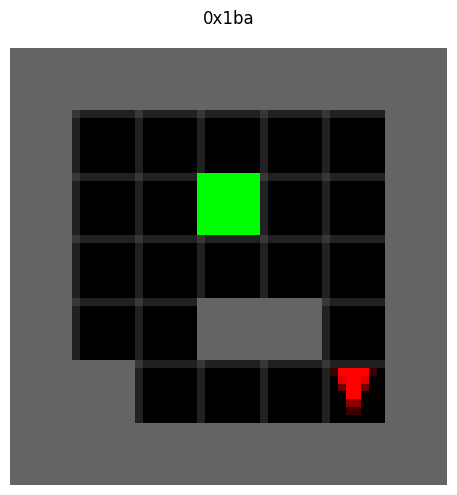

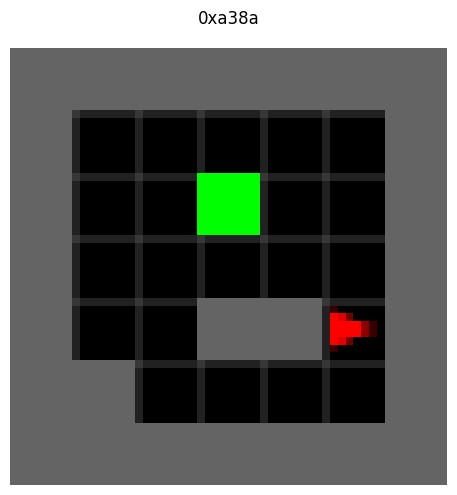

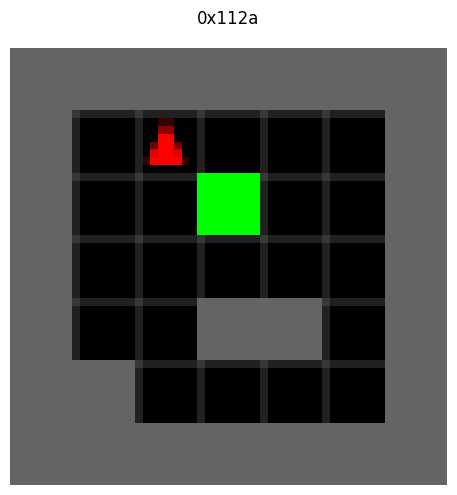

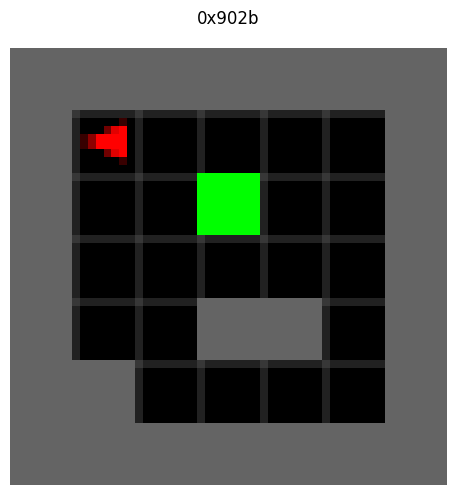

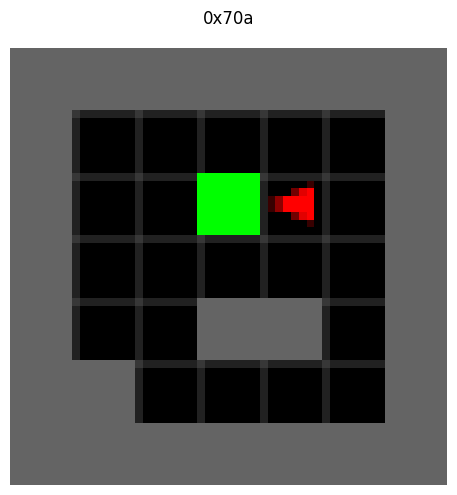

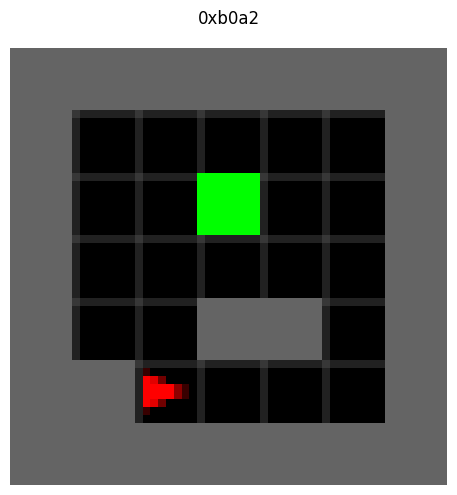

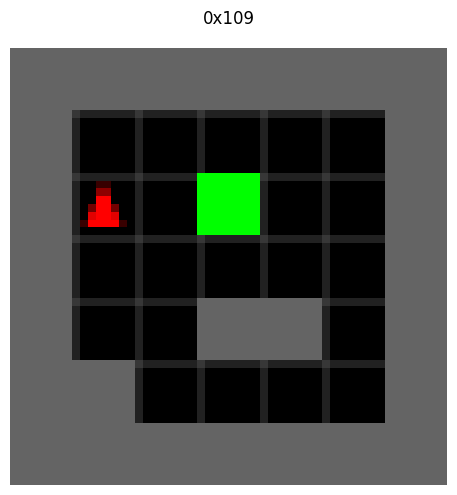

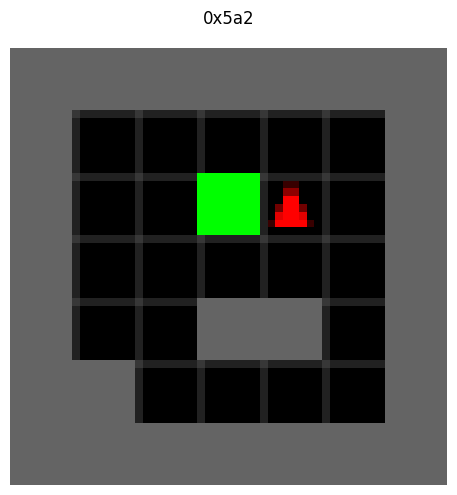

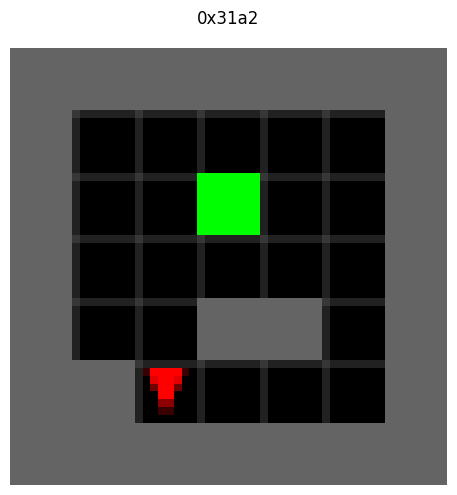

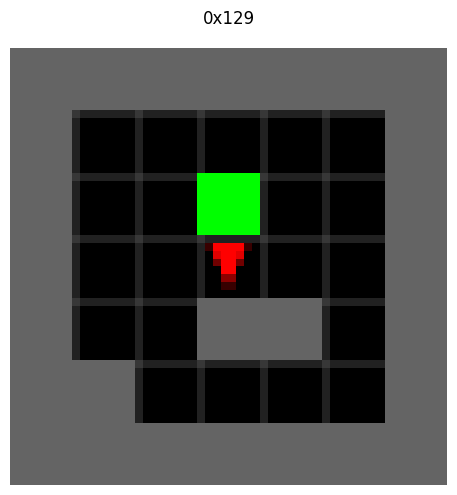

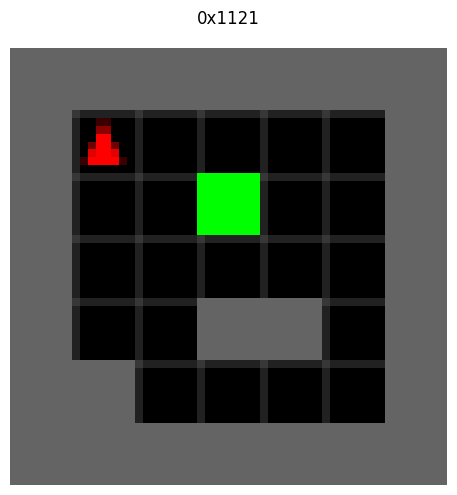

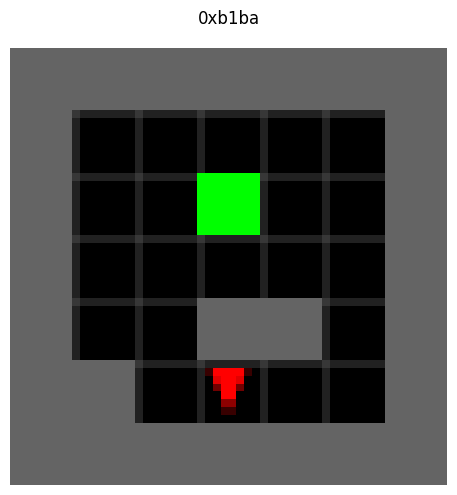

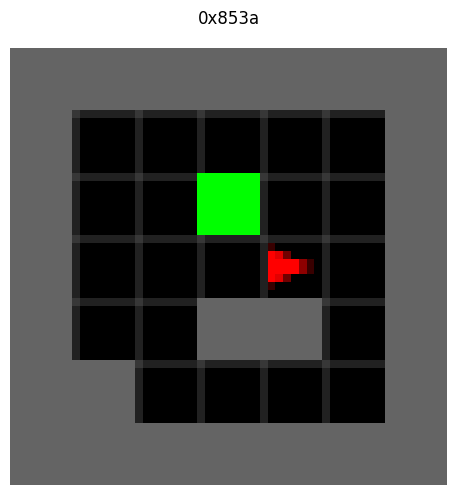

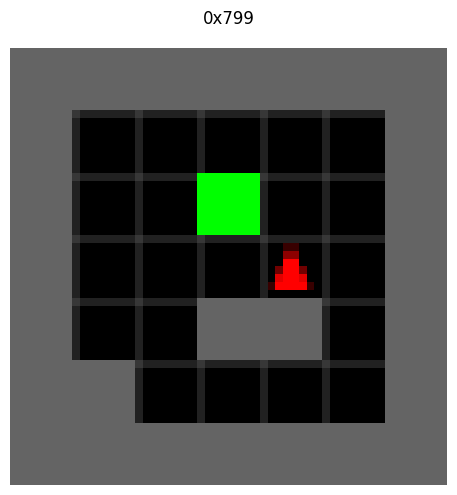

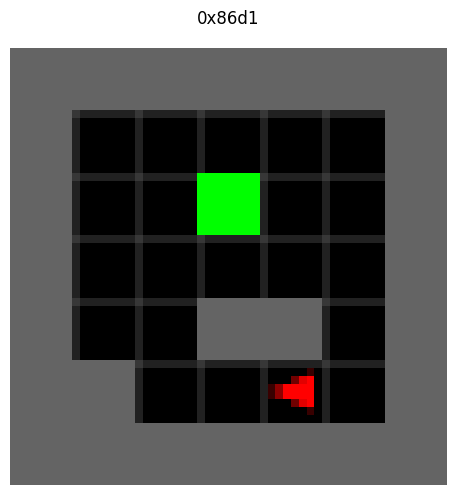

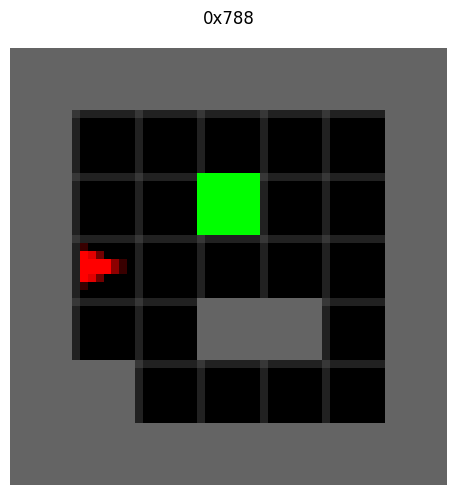

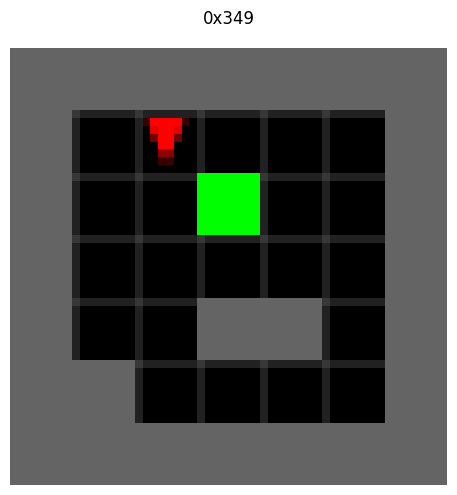

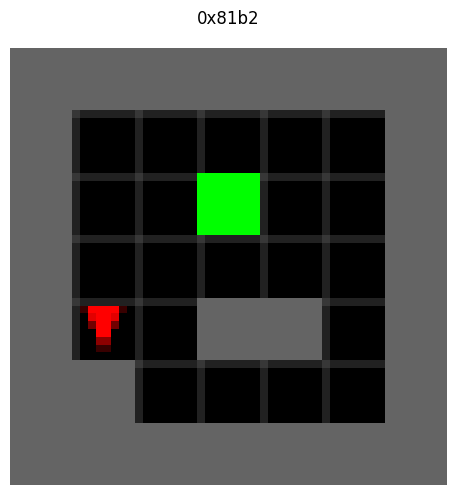

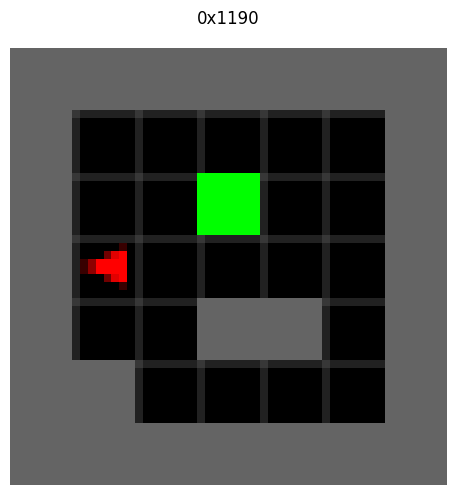

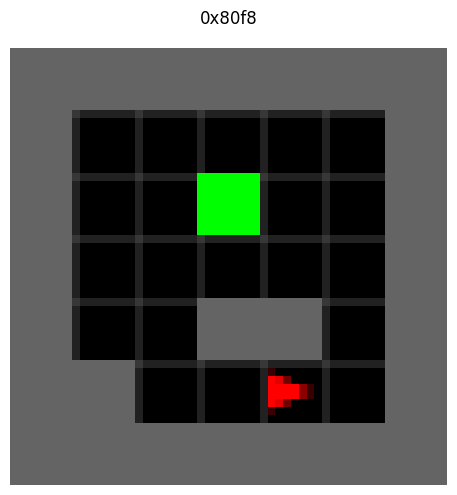

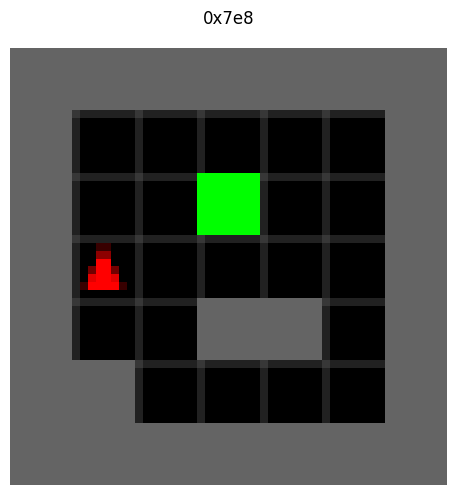

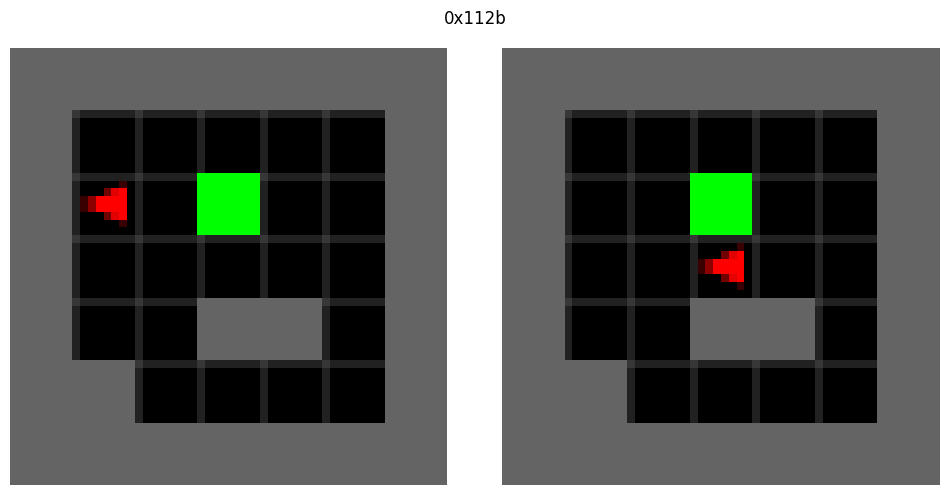

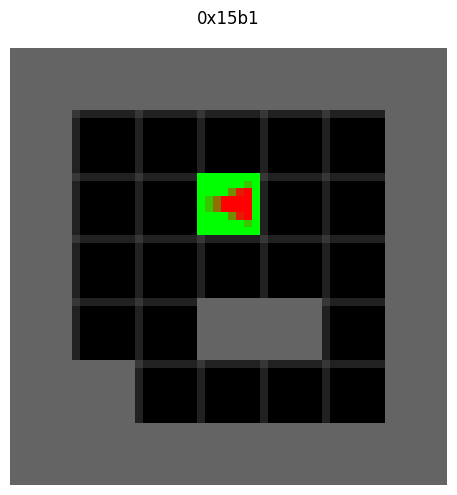

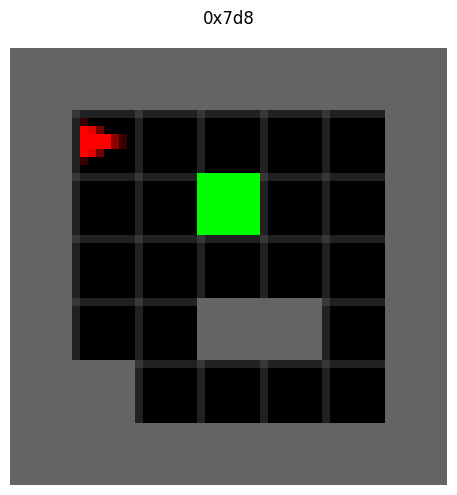

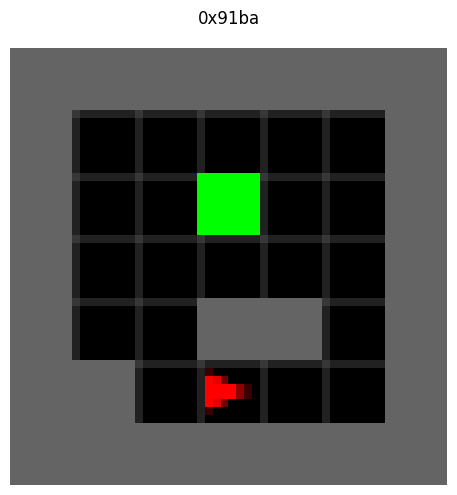

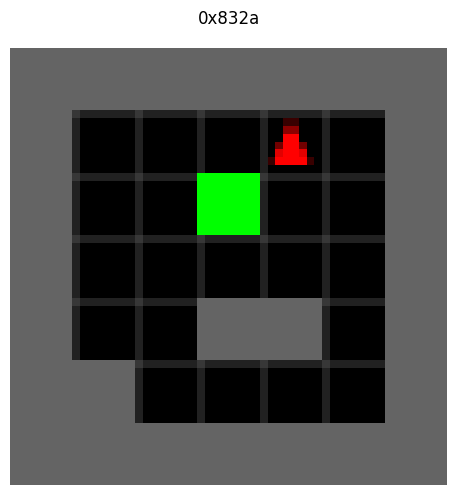

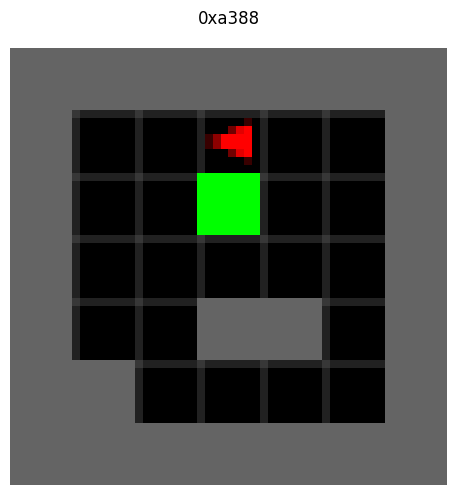

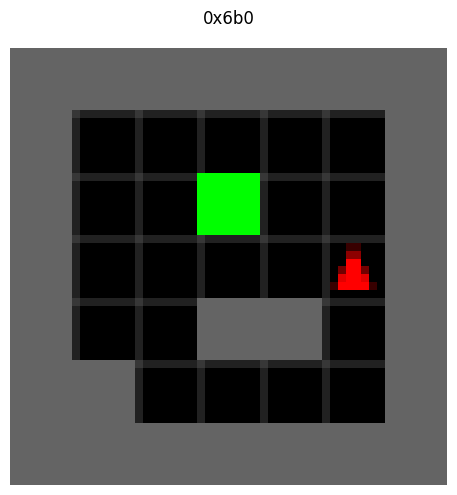

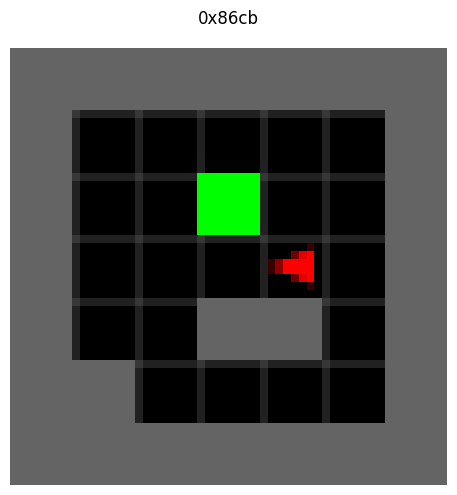

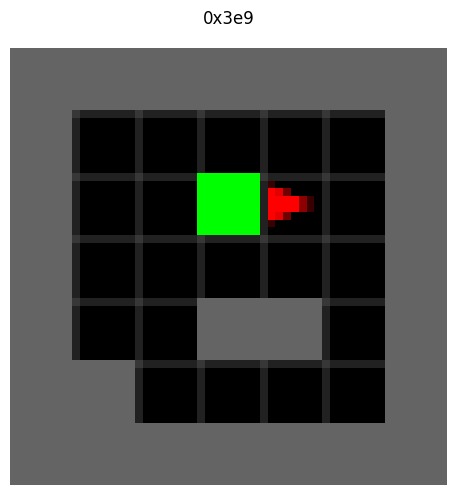

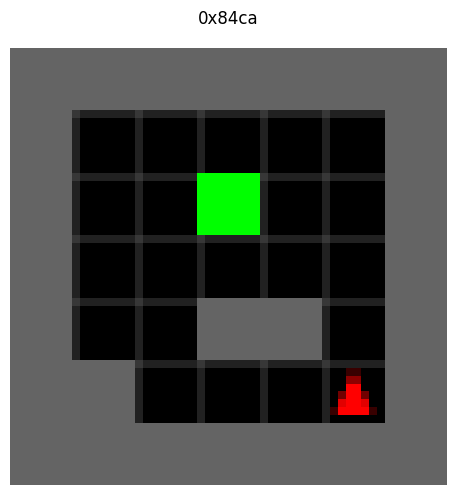

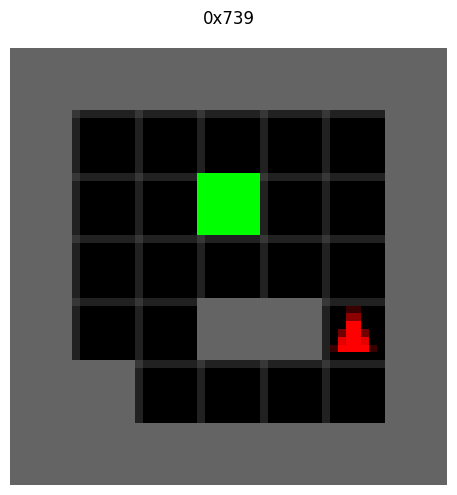

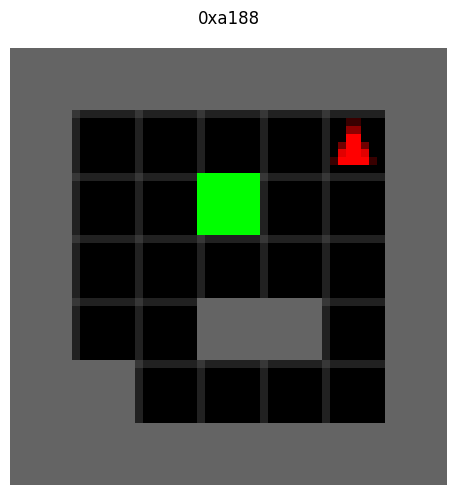

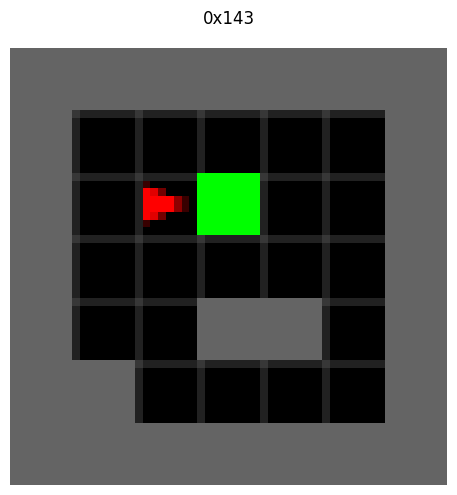

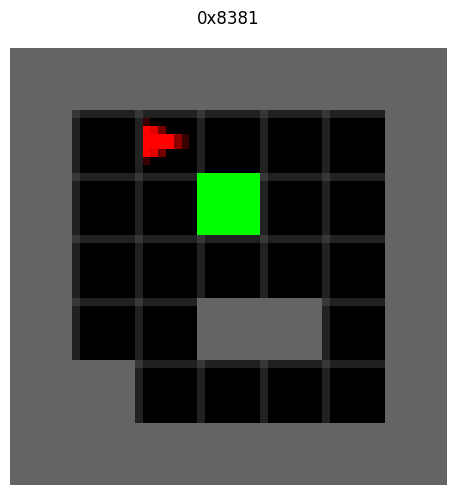

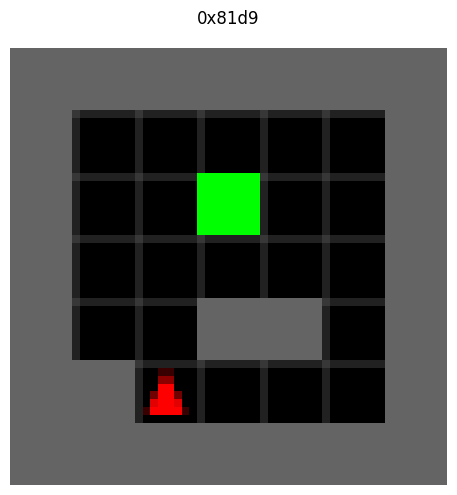

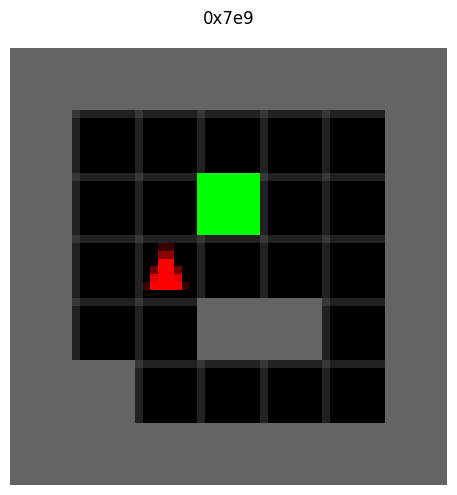

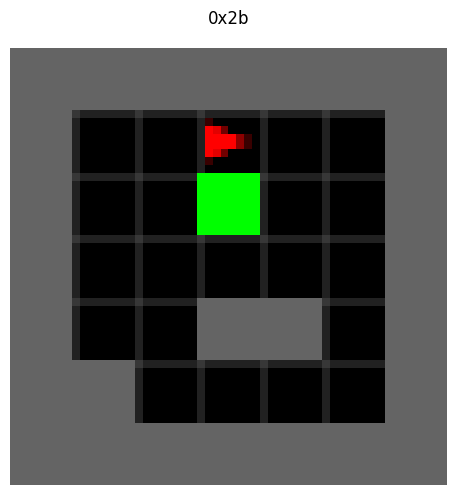

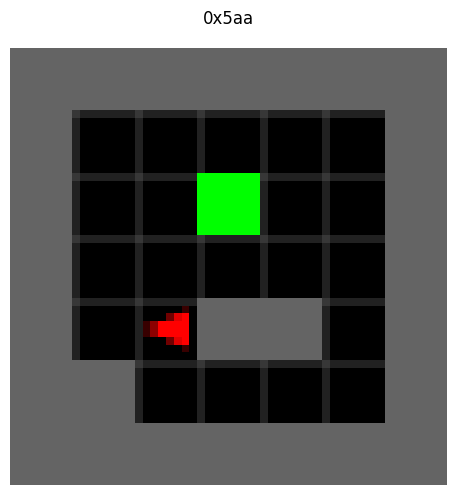

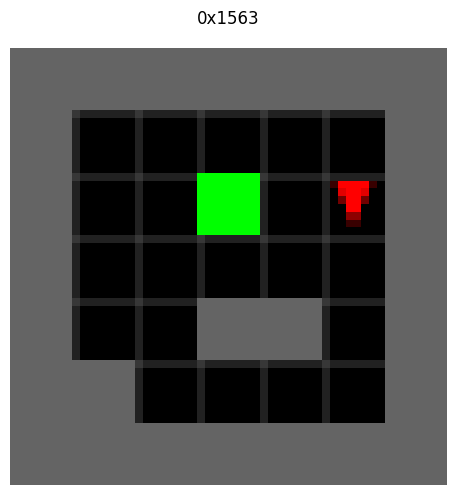

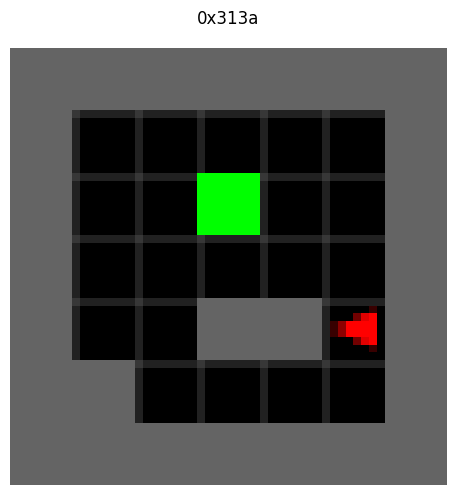

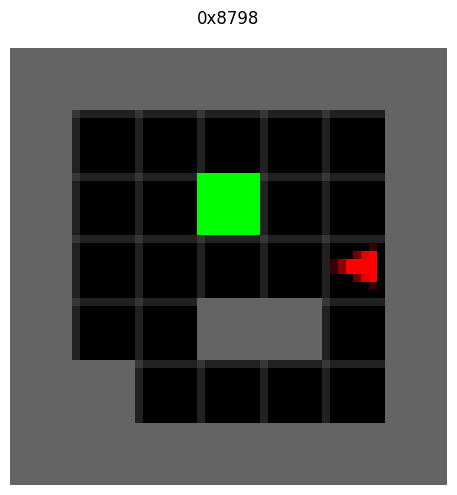

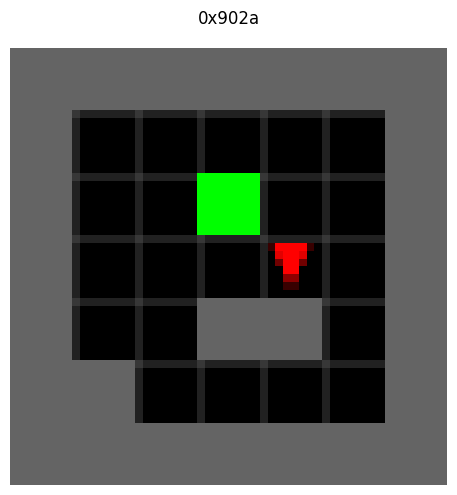

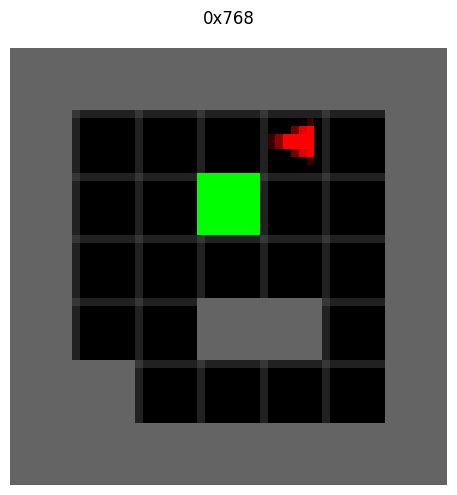

In [12]:
from minigrid_abstract_encoding import EncodingMDPLearner
from stable_baselines3 import PPO

file_paths = [
    f'./maps/7-{i}.txt' for i in range(1, 2)
]
env_list = []
for file_path in file_paths:
    env = CustomEnv(
        txt_file_path=file_path,
        rand_gen_shape=None,
        display_size=7,
        display_mode="middle",
        agent_start_pos=(5, 5),
        agent_start_dir=0,
        random_rotate=False,
        random_flip=False,
        custom_mission="Find the key and open the door.",
        render_mode=None,
    )
    env.reset()
    img = env.get_frame(False, env.tile_size, env.agent_pov)
    plt.imshow(img)
    plt.show()
    env = FullyObsImageWrapper(env, to_print=False)
    env_list.append(env)

load_path = r'experiments/mazes-bin-16/run0/saved_models/saved_model_latest.zip'
model = PPO.load(load_path, env=env)
feature_model = model.policy.features_extractor
feature_model.binary_output = True
feature_model.to("cpu")

encoded_state_set = set()
learners = []
for env in env_list:
    one_hot_learner = OneHotEncodingMDPLearner(env)
    one_hot_learner.learn()
    optimal_graph = OptimalPolicyGraph()
    optimal_graph.load_graph(one_hot_learner.mdp_graph)
    optimal_graph.uniform_prior_policy()
    optimal_graph.visualize(highlight_states=[one_hot_learner.start_state, *one_hot_learner.done_states], use_grid_layout=False, display_state_name=False)
    
    encoding_learner = EncodingMDPLearner(env, feature_model, torch.device("cpu"), keep_dims=feature_model.features_dim)
    encoding_learner.learn()
    optimal_graph = OptimalPolicyGraph()
    optimal_graph.load_graph(encoding_learner.mdp_graph)
    optimal_graph.uniform_prior_policy()
    optimal_graph.visualize(highlight_states=[encoding_learner.encoded_start_state, *encoding_learner.encoded_done_states], use_grid_layout=False, display_state_name=True)

    encoded_state_set = encoded_state_set | set(encoding_learner.encoded_state_set)
    learners.append(encoding_learner)

max_cols = 3
for state in encoding_learner.encoded_state_set:
    images = encoding_learner.encoded_state_to_unencoded_state_dict[state]
    num_images = len(images)
    num_rows = (num_images + max_cols - 1) // max_cols
    num_cols = min(num_images, max_cols)
    plt.figure(figsize=(num_cols * 5, num_rows * 5))
    for i, unencoded in enumerate(images):
        img = encoding_learner.unencoded_state_image_dict[unencoded]
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(state)
    plt.tight_layout()
    plt.show()

# max_cols = 3
# for state in encoded_state_set:
#     images = []
#     imgs = []
#     for learner in learners:
#         if state in learner.encoded_state_to_unencoded_state_dict.keys():
#             images += learner.encoded_state_to_unencoded_state_dict[state]
#             imgs.append(learner.unencoded_state_image_dict[images])
#     num_images = len(images)
#     num_rows = (num_images + max_cols - 1) // max_cols
#     num_cols = min(num_images, max_cols)
#     plt.figure(figsize=(num_cols * 5, num_rows * 5))
#     for i, unencoded, img in enumerate(zip(images, imgs)):
#         # for learner in learners:
#         #     if learner.unencoded_state_image_dict.keys()
#         #     img = learner.unencoded_state_image_dict[unencoded]
#         plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(img)
#         plt.axis('off')
#     plt.suptitle(state)
#     plt.tight_layout()
#     plt.show()
# 假设 encoded_state_set 和 learners 已经定义
# 假设 encoded_state_set 和 learners 已经定义
# for state in encoded_state_set:
#     images = []
#     imgs = []
#     for learner in learners:
#         if state in learner.encoded_state_to_unencoded_state_dict.keys():
#             images += learner.encoded_state_to_unencoded_state_dict[state]
#             a = list(learner.encoded_state_to_unencoded_state_dict[state])
#             for aa in a:
#                 b = learner.unencoded_state_image_dict[aa]
#                 plt.figure()
#                 plt.imshow(b)
#                 plt.show()
#                 exit()
#                 imgs.append(learner.unencoded_state_image_dict[aa])
# 
#     # 为每个 imgs 中的列表绘图，每行显示5个
#     for img_list in imgs:
#         num_images = len(img_list)
#         num_rows = (num_images + 4) // 5  # 计算需要多少行
#         fig, axes = plt.subplots(num_rows, min(num_images, 5), figsize=(15, 3 * num_rows))
#         fig.suptitle(f"State: {state}")
#         
#         # 如果只有一行，axes可能不是二维数组，需要处理这种情况
#         if num_images <= 5:
#             axes = np.array([axes])  # 将axes变成二维数组
#         
#         for i, ax in enumerate(axes.flat):
#             if i < num_images:
#                 ax.imshow(img_list[i])
#                 ax.axis('off')
#             else:
#                 ax.axis('off')  # 超出部分的轴关闭
#         plt.show()
